# Import

In [1]:
import numpy as np
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from tqdm import tqdm
from scipy.signal import spectrogram
import matplotlib.pyplot as plt
from skimage.transform import resize
import torchvision.transforms as transforms
from torch.nn.functional import normalize

# Read datafile

In [2]:
def get_data_paths(folder_path):
    data_train_paths = []
    label_train_paths = []
    data_val_paths = []
    label_val_paths = []
    for file in os.listdir(folder_path):
        if 'info' in file.lower():
            continue
        if "03T" in file:
            if "data" in file:
                data_train_paths.append(folder_path + "/" + file)
            else:
                label_train_paths.append(folder_path + "/" + file)
        elif "05E" in file:
            if "data" in file:
                data_val_paths.append(folder_path + "/" + file)
            else:
                label_val_paths.append(folder_path + "/" + file)
    return data_train_paths, label_train_paths, data_val_paths, label_val_paths

In [3]:
folder_path = 'bci2b-npy'
data_train_paths, label_train_paths, data_val_paths, label_val_paths = get_data_paths(folder_path)

# EEG to feature image

In [4]:
def convert_to_feature_img_tensor(eeg_signal_tensor, img_size):
    imgg = []
    for i in range(eeg_signal_tensor.shape[1]):
        f, t, Sxx = spectrogram(eeg_signal_tensor[:,i], fs= 256) # fs là tần số lấy mẫu
        imgg.append(Sxx)
        
    feature_map = np.stack(imgg, axis=-1)
    feature_map_resized = np.zeros((img_size, img_size, 3))  # Tạo tensor rỗng
    for i in range(3):  # Resize từng kênh
        feature_map_resized[:, :, i] = resize(
            feature_map[:, :, i], (img_size, img_size), mode='reflect'
        )
    min_val = np.min(feature_map_resized)
    max_val = np.max(feature_map_resized)
    feature_map_resized = (feature_map_resized - min_val)/(max_val - min_val)
    feature_map_resized = feature_map_resized*255
    return feature_map_resized # img_size x img_size x channel
    

# Data class

In [5]:
class BCI_data(Dataset):
    def __init__(self, data_paths, label_paths, transforms):
        self.data_paths = data_paths
        self.label_paths = label_paths
        self.data = []
        self.label = []
        self.transform = transforms
        self.all_data = self.get_all_data()
    def __len__(self):
        return len(self.all_data)
    def __getitem__(self, index):
        return self.transform(convert_to_feature_img_tensor(self.all_data[index][0], 224)), self.all_data[index][1]
    def get_all_data(self):
        for idx in range(len(self.data_paths)):
            data_before = np.load(self.data_paths[idx])
            label_before = np.load(self.label_paths[idx])
            self.transform_data(data_before, label_before)
        result = [[self.data[i], self.label[i]] for i in range(len(self.data))]
        return result
    def transform_data(self, data, label):
        for da in data:
            self.data.append(torch.Tensor(da))
        for la in label:
            self.label.append(torch.Tensor(la))

In [6]:
transforms_data = transforms.Compose([
    transforms.ToTensor(),
])

In [7]:
dataset_train = BCI_data(data_train_paths, label_train_paths, transforms_data)
dataset_val = BCI_data(data_val_paths, label_val_paths, transforms_data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'left')

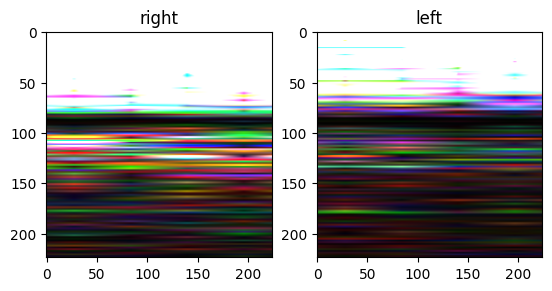

In [8]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(dataset_train.__getitem__(4)[0].permute(1,2,0))
ax[0].set_title("left" if torch.equal(dataset_train.__getitem__(4)[1], torch.Tensor([1., 0.])) else "right")
ax[1].imshow(dataset_train.__getitem__(5)[0].permute(1,2,0))
ax[1].set_title("left" if torch.equal(dataset_train.__getitem__(5)[1], torch.Tensor([1., 0.])) else "right")


# Dataloader

In [9]:

batch_size = 8

In [10]:
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

In [11]:
signal, label = next(iter(dataloader_train))
signal.shape

torch.Size([8, 3, 224, 224])

In [12]:
print(signal[4])
print(label[4])

tensor([[[2.1689e+01, 2.2161e+01, 2.2632e+01,  ..., 9.1112e+00,
          8.9290e+00, 8.7468e+00],
         [3.4664e+01, 3.5407e+01, 3.6149e+01,  ..., 1.5360e+01,
          1.5047e+01, 1.4733e+01],
         [8.3894e+01, 8.5664e+01, 8.7433e+01,  ..., 3.9069e+01,
          3.8258e+01, 3.7447e+01],
         ...,
         [4.0997e-01, 4.1945e-01, 4.2894e-01,  ..., 4.3327e-01,
          4.4083e-01, 4.4840e-01],
         [1.6452e-01, 1.6844e-01, 1.7236e-01,  ..., 3.5254e-01,
          3.4967e-01, 3.4681e-01],
         [9.9834e-02, 1.0228e-01, 1.0473e-01,  ..., 3.3126e-01,
          3.2564e-01, 3.2003e-01]],

        [[4.9774e+01, 4.9947e+01, 5.0119e+01,  ..., 1.4187e+00,
          1.4737e+00, 1.5288e+00],
         [8.3055e+01, 8.3269e+01, 8.3482e+01,  ..., 2.4009e+00,
          2.4945e+00, 2.5881e+00],
         [2.0933e+02, 2.0970e+02, 2.1007e+02,  ..., 6.1273e+00,
          6.3674e+00, 6.6074e+00],
         ...,
         [2.5203e-02, 2.5022e-02, 2.4841e-02,  ..., 8.9657e-03,
          9.195

# Model

In [13]:
class CNN_model(nn.Module):
    def __init__(self, activation):
        super(CNN_model, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.batch_normalize1 = nn.BatchNorm2d(num_features=32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 32x112x112
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batch_normalize2 = nn.BatchNorm2d(num_features=64)
        self.conv6 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 64x56x56
        self.conv7 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.batch_normalize3 = nn.BatchNorm2d(num_features=128)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 128x28x28
        self.fc1 = nn.Linear(in_features=128*28*28, out_features=500, bias=True)
        self.fc2 = nn.Linear(in_features=500, out_features=2, bias=True)
        self.activation = activation
        self.dropout = nn.Dropout(p = 0.1)
    def forward(self,x):
        x = x.float()
        x = self.conv1(x)
        x = self.batch_normalize1(x)
        x = self.activation(x)
        
        x = self.conv2(x)
        x = self.batch_normalize1(x)
        x = self.activation(x)

        x = self.conv3(x)
        x = self.batch_normalize1(x)
        x = self.activation(x)

        x = self.conv4(x)
        x = self.batch_normalize1(x)
        x = self.activation(x)

        x = self.maxpool1(x)

        x = self.conv5(x)
        x = self.batch_normalize2(x)
        x = self.activation(x)

        x = self.conv6(x)
        x = self.batch_normalize2(x)
        x = self.activation(x)

        x = self.maxpool2(x)

        x = self.conv7(x)
        x = self.batch_normalize3(x)
        x = self.activation(x)

        x = self.maxpool3(x)

        x = x.view(-1, 128*28*28)
        x = self.fc1(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.dropout(x)

        return x



## check model and output of model

In [14]:
model_check = CNN_model(nn.ELU())

In [15]:
out_check = model_check(signal)

In [16]:
out_check

tensor([[ 0.2647, -0.2061],
        [ 0.0926, -0.0726],
        [ 0.1219, -0.2753],
        [ 0.3494, -0.4988],
        [ 0.2532, -0.7715],
        [ 0.2329, -0.1070],
        [-0.1580, -0.2787],
        [ 0.4263, -0.2834]], grad_fn=<MulBackward0>)

In [17]:
torch.argmax(out_check, dim=1)

tensor([0, 0, 0, 0, 0, 0, 0, 0])

In [18]:
torch.argmax(label, dim=1)

tensor([0, 1, 0, 1, 0, 0, 1, 0])

## model

In [19]:
model = CNN_model(nn.ELU())

# Trainner

In [20]:
class Trainer:
    def __init__(self, dataloader_train, dataloader_val, model, optimizer, criterion, epochs=1):
        self.dataloader_train = dataloader_train
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.epochs = epochs
        self.dataloader_val = dataloader_val
        self.history_loss = []
        self.history_acc = []
    def val(self, model_val, device):
        torch.cuda.empty_cache()
        pbar_val = tqdm(self.dataloader_val)
        total_val = 0
        total_correct_val = 0
        for a, b in pbar_val:
            a = a.to(device)
            b = b.to(device)
            out = model_val(a)
            total_correct_val += (torch.argmax(out, dim=1) == torch.argmax(b, dim=1)).sum().item()
            total_val += b.size(0)
            acc_val = total_correct_val/total_val
            pbar_val.set_description(f'Acc_val: {acc_val}')
    def train(self):
        torch.cuda.empty_cache()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = self.model
        model.to(device)
        optimizer = self.optimizer
        criterion = self.criterion
        for epoch in range(self.epochs):
            model.train()
            pbar = tqdm(self.dataloader_train)
            total = 0
            total_correct = 0
            for X, y in pbar:
                optimizer.zero_grad()
                X = X.to(device)
                y = y.to(device)
                yh = model(X)
                yh = yh.to(device)
                loss = criterion(yh, y)
                loss.backward()
                optimizer.step()
                total_correct += (torch.argmax(yh, dim=1) == torch.argmax(y, dim=1)).sum().item()
                total += y.size(0)
                acc = total_correct/total
                pbar.set_description(f'Loss: {loss.item()}, Acc: {acc}')
                self.history_loss.append(loss.item())
                self.history_acc.append(acc)
            self.val(model, device)

In [21]:
trainer = Trainer(dataloader_train, dataloader_val, model, torch.optim.Adam(model.parameters(), lr=0.000001), nn.CrossEntropyLoss(), epochs=5)

In [22]:
trainer.train()

Acc_val: 0.7138888888888889: 100%|██████████| 180/180 [00:28<00:00,  6.21it/s]
Loss: 0.5663154721260071, Acc: 0.7423611111111111: 100%|██████████| 180/180 [00:55<00:00,  3.25it/s] 
Acc_val: 0.61875: 100%|██████████| 180/180 [00:25<00:00,  7.11it/s]           
Loss: 0.6313742995262146, Acc: 0.7743055555555556: 100%|██████████| 180/180 [00:55<00:00,  3.26it/s] 
Acc_val: 0.7611111111111111: 100%|██████████| 180/180 [00:24<00:00,  7.29it/s]
Loss: 0.25385886430740356, Acc: 0.8076388888888889: 100%|██████████| 180/180 [00:54<00:00,  3.31it/s]
Acc_val: 0.7520833333333333: 100%|██████████| 180/180 [00:24<00:00,  7.30it/s]


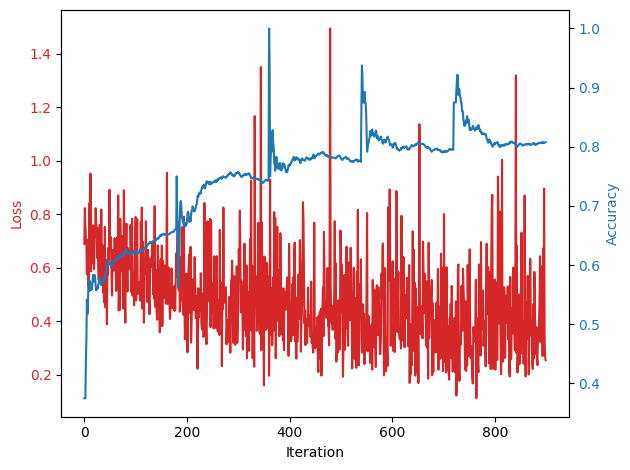

In [23]:
history_loss = trainer.history_loss
history_acc = trainer.history_acc
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss', color=color)
ax1.plot(history_loss, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(history_acc, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()